https://www.tensorflow.org/tutorials/keras/regression

## Modelo

Arbol de decisión de nuestro algoritmo de Maching Learning
<img src="ml_map.png">

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pandas as pd
import pickle
import pprint

In [31]:
# read the clean data
df = pd.read_csv('all_data_clean_ordinal.csv')
print(df.shape)
df.head()

(23183, 29)


,Excel Company ID,Rating,Sector,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,Total Debt,...,Quick Ratio,Cash ratio,Debt to Equity,Debt ratio,Rating_group,Net Debt,Financial Leverage_group,Sector_ordinal,Rating_ordinal,Rating_group_ordinal
0,IQ5522615,AAA,Industrials,131.88622,40.31142,79.35595,948.46022,375.10682,140.04878,298.03042,...,0.319022,0.107467,0.815138,3.182428,AAA,257.71900,"(1.116, 3.881]",2,1,0.0
1,IQ4112645,AAA,Industrials,19851.15657,1694.92907,17057.47764,59124.55826,12387.79077,36441.35861,43611.62214,...,1.513781,0.136823,5.753375,1.355706,AAA,41916.69307,"(12.135, 14.886]",2,1,0.0
2,IQ134385765,AAA,Financials,56290.37100,382.95500,53255.75500,187664.38700,125659.11500,58822.43600,159460.40600,...,0.426859,0.003048,5.753375,1.176871,AAA,159077.45100,"(12.135, 14.886]",3,1,0.0
3,IQ12465523,AAA,Industrials,166.71682,10.61747,135.99393,1993.93763,583.17000,232.45475,530.76038,...,0.251404,0.018206,0.828456,3.756757,AAA,520.14291,"(1.116, 3.881]",2,1,0.0
4,IQ139677,AAA,Health Care,40948.66165,15191.95565,8503.05235,96321.22385,18638.76625,9689.25465,13216.64570,...,1.271276,0.815073,0.245851,7.287872,AAA,-1975.30995,"(1.116, 3.881]",8,1,0.0


In [63]:
var_x_num = ["Net Debt to EBITDA", "Debt to Assets", "Current Ratio", "Quick Ratio", "Cash ratio", "Long Term Debt to Equity","Debt to Equity", "Debt ratio", "Financial Leverage"]
var_x = [x for x in var_x_num if x != 'Debt to Assets' and x != 'Debt to Equity'] + ['Sector_ordinal']
var_y = ['Rating_ordinal']
df_model = df[var_y + var_x]
df_model.head()

,Rating_ordinal,Net Debt to EBITDA,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal
0,1,1.942794,0.351596,0.319022,0.107467,0.383045,3.182428,2.594117,2
1,1,15.000000,1.602478,1.513781,0.136823,4.593871,1.355706,14.886094,2
2,1,15.000000,0.447961,0.426859,0.003048,4.593871,1.176871,14.886094,3
3,1,3.084394,0.285880,0.251404,0.018206,0.362835,3.756757,3.112306,2
4,1,0.000000,2.196962,1.271276,0.815073,0.180236,7.287872,1.791730,8


In [67]:
df_model = df_model.dropna()
# Tranformar la columna rating_group_ordinal a int
df_model['Rating_ordinal'] = df_model['Rating_ordinal'].astype(int)
# XXX lo reordenamos pero hay que ver porque faltan estos
set(range(1,27)) - set(df_model['Rating_ordinal'])

{2, 22, 23, 24}

In [69]:
# reorder the column Rating_ordinal to start from 0 to 26
for i,ordinal in enumerate(set(df_model['Rating_ordinal'])):
    df_model['Rating_ordinal'] = df_model['Rating_ordinal'].replace(ordinal, i)
set(df_model['Rating_ordinal'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [42]:
# XXX hacemos un apaño para que entre en el modeo pero hay qe ver porque no tengo 8
mask = df_model['Rating_group_ordinal'] == 9
df_model.loc[mask, 'Rating_group_ordinal'] = 8

In [70]:
df_model.describe().transpose() # XXX ver ti tambien es importante el año

,count,mean,std,min,25%,50%,75%,max
Rating_ordinal,23183.0,8.807618,3.420669,0.000000,7.000000,8.000000,11.000000,21.000000
Net Debt to EBITDA,23183.0,4.466823,3.769385,0.000000,1.883149,3.421204,5.693014,15.000000
Current Ratio,23183.0,1.265094,0.644012,-1.810261,0.815800,1.168088,1.600198,4.204907
Quick Ratio,23183.0,0.743553,0.389758,0.000000,0.448677,0.695380,0.992845,2.011484
Cash ratio,23183.0,0.272413,0.230250,-0.012686,0.085664,0.216185,0.404038,0.961125
Long Term Debt to Equity,23183.0,1.195916,1.142892,0.000000,0.466426,0.811940,1.394323,4.593871
Debt ratio,23183.0,3.252083,1.656280,0.452000,2.110077,2.813754,3.845122,10.164151
Financial Leverage,23183.0,3.840507,2.946880,1.129610,2.193579,2.872578,4.040411,14.886094
Sector_ordinal,23183.0,4.930423,3.086806,0.000000,2.000000,5.000000,7.000000,10.000000


In [62]:
# count the number of rows for each rating
df['Rating'].value_counts()

Rating
BBB     3434
BBB+    3097
A-      2454
BBB-    2341
BB      1783
BB+     1619
BB-     1516
B+      1287
B       1237
A       1212
A+       815
B-       648
AA-      453
AA       361
CCC+     302
AA+      249
CCC      127
AAA      102
D         69
CCC-      45
SD        20
CC        12
Name: count, dtype: int64

Ya tenemos los datos limpios y podemos empezar a crear el modelo.

Dado que tu variable objetivo, "Rating", es categórica y tiene un orden intrínseco, y estás interesado en predecirla a partir de una serie de variables predictoras tanto numéricas como categóricas, el tipo de regresión más adecuado para tu análisis sería una regresión ordinal.

La regresión ordinal es una variante de regresión lineal que es adecuada para variables dependientes categóricas con un orden claro, como es el caso de tu variable "Rating". A diferencia de la regresión lineal clásica, que asume una variable dependiente continua, o de los modelos de clasificación como la regresión logística, que tratan con categorías sin un orden inherente, la regresión ordinal considera el orden natural entre las categorías de la variable de respuesta.

In [35]:
import mord # XXX update requirements.txt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [71]:
# Asumiendo que df es tu DataFrame y ya has transformado "sector" a numérica y "Rating" a ordinal
X = df_model[var_x]
y = df_model[var_y]

In [72]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización de los predictores
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
# Ajustar el modelo de regresión ordinal
model = mord.LogisticAT(alpha=1.0)  # LogisticAT es uno de los modelos disponibles en mord
model.fit(X_train_scaled, y_train.values)

c:\Users\Ruben\Documents\PhD_AI\Clases\estadistica\rating_analisis\env_ratings\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticAT()

In [74]:
# Hacer predicciones
y_pred = model.predict(X_test_scaled)
y_pred

array([8, 8, 8, ..., 8, 8, 9])

In [75]:
from sklearn.metrics import mean_absolute_error

# Aquí podrías calcular métricas de rendimiento, como la precisión o el Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2.4323916325210266


In [77]:
All_rating_order_group = {'AAA+':'AAA','AAA':'AAA','AAA-':'AAA',
                    'AA+':'AA','AA':'AA','AA-':'AA','A+':'A','A':'A','A-':'A',
                    'BBB+':'BBB','BBB':'BBB','BBB-':'BBB','BB+':'BB','BB':'BB','BB-':'BB','B+':'B','B':'B','B-':'B',
                    'CCC+':'CCC','CCC':'CCC','CCC-':'CCC','CC':'CC','C+':'C','C':'C','C-':'C','D':'D'}
All_rating_order_group.keys()

dict_keys(['AAA+', 'AAA', 'AAA-', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C+', 'C', 'C-', 'D'])

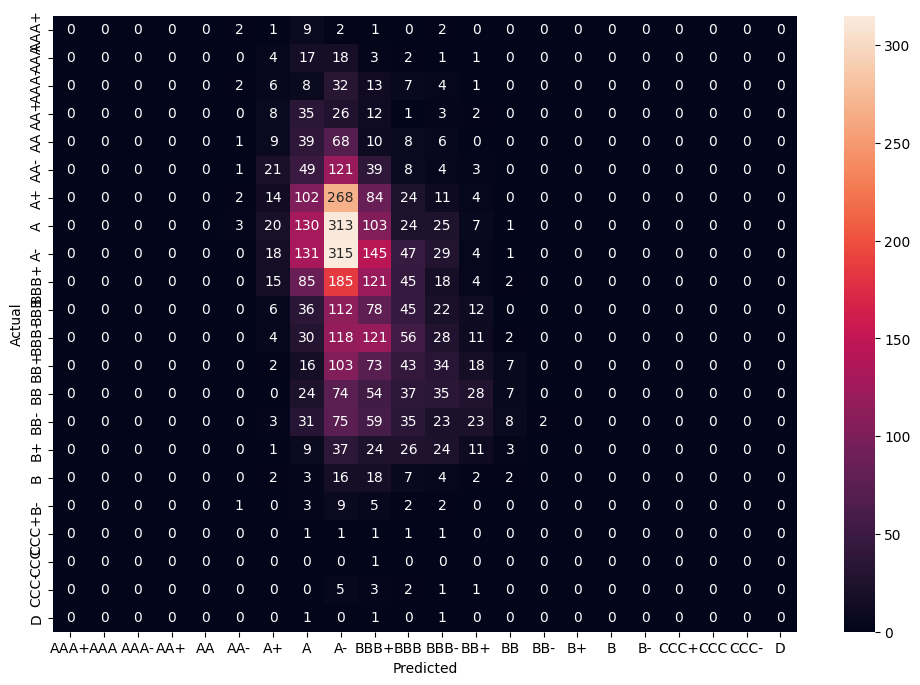

In [80]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d")
# change the x and y tick labels by the rating ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'D']
plt.xticks(ticks=[0.5 + i for i in range(22)], labels=['AAA+', 'AAA', 'AAA-', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'D'])
plt.yticks(ticks=[0.5 + i for i in range(22)], labels=['AAA+', 'AAA', 'AAA-', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'D'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [56]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.40578458881933954


In [57]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {kappa}")


Cohen's Kappa: 0.08411469368196944


In [ ]:
# XXX Sacar el IBEX 35 y todas las comparables de los WACC que hemos hecho y ver que predicen y que rating real tienen 

In [82]:
svm_clf = Pipeline([
("scaler", StandardScaler()),
("linear_svc", LinearSVC(C=1, loss="hinge", max_iter=500)),
])
svm_clf.fit(X, y)

c:\python\python38-32\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', max_iter=500))])

Medimos el error con los datos de testeo

In [83]:
X[1]

array([1.10000000e+01, 9.00970730e-01, 1.30018220e-01, 1.75714451e-01,
       3.29054265e-05, 1.94324351e-05, 1.11304648e-03, 8.79585188e-01,
       9.06104745e-01, 1.22187960e-06, 9.22177368e-01])

In [84]:
svm_clf.predict([X[1]]),y[1]

(array([17.]), 1.0)

## Guardar y cargar el modelo

Ahora guardamos los parámtros del modelo y lo guaradamos para poder usarlo rapidamente desde excel

Guardamos el modelo

In [85]:
model = svm_clf
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Cargamos el modelo para usarlo

In [86]:
loaded_model = pickle.load(open(filename, 'rb'))

In [87]:
output_model = loaded_model.predict([X[10]])
X[10],output_model,y[10]

(array([1.10000000e+01, 9.01106948e-01, 1.29961514e-01, 1.73846855e-01,
        2.98227691e-05, 1.24296606e-05, 3.73541934e-04, 8.79524633e-01,
        9.06058712e-01, 1.92278691e-05, 9.22163874e-01]),
 array([17.]),
 1.0)

In [88]:
invers_dict_rating = {v:k for k, v in replace_map['Rating'].items()}
invers_dict_rating[int(output_model)],invers_dict_rating[int(y[10])]

('B-', 'AAA')

Funcion que se llamara desde execel para usar el modelo

In [171]:
def estimate_rating(escalados,Sector,EBITDA_Gastos_financieros,DFN_EBITDA,Deuda_Deuda_Equity,Current_Ratio,Quick_Ratio,
                    Cash_Ratio,LT_Debt_to_equity,Total_Debt_to_Equity,Debt_Ratio,Financial_Leverage):
    
    Sectors = {'Communication_Services': 0,'Consumer_Discretionary': 9,'Consumer_Staples': 8,'Energy': 7,
              'Financials': 11,'Health_Care': 4,'Industrials': 2,
              'Information_Technology': 1,'Materials': 5,'Real_Estate': 10,'Utilities': 3}
    
    All_rating_order = ['AAA+','AAA','AAA-','AA+','AA','AA-','A+','A','A-','BBB+','BBB','BBB-','BB+','BB','BB-','B+','B',
                   'B-','CCC+','CCC','CCC-','CC','C+''C','C-','D']
    
    replace_map = {'Sector':{industry:code for industry,code  in Sectors.items()},
                   'Rating':{i:rating for i,rating in enumerate(All_rating_order)}}
    
    try:
        X = [replace_map['Sector'][Sector],EBITDA_Gastos_financieros,DFN_EBITDA,Deuda_Deuda_Equity,
             Current_Ratio,Quick_Ratio,Cash_Ratio,LT_Debt_to_equity,Total_Debt_to_Equity,Debt_Ratio,Financial_Leverage]
    except Exception as e:
        if type(e).__name__ == 'TypeError':
            print('Error en tipo de sector. Los secoteres disponibles son:',Sector.keys())
        else:
            print(e)
    #Faltaria leer los datos de escalados       
    if not escalados:
        X = escalado_nuevo(np.array(X[1:]),np.array(escalados_1),np.array(escalados_2),metodo)
        X = [replace_map['Sector'][Sector]] + list(X)
        
    filename = 'finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    output_model = loaded_model.predict([X])
    return replace_map['Rating'][int(output_model)]

In [169]:
estimate_rating(True, *['Industrials'] + X[1][1:].tolist())

'AA-'

### Inputs reales
En la realidad pasariamos los datos sin escalar

In [92]:
df_ready.iloc[0]

Excel Company ID                    IQ4149300
ID                             2018-IQ4149300
Company Name                     KOSE:A002380
Rating                                     10
Sector                                     11
EBITDA / Gastos financieros           22.3745
DFN / EBITDA                          3.48727
Deuda / (Deuda + Equity)             0.277097
Current Ratio                        0.941897
Quick Ratio                           0.54896
Cash Ratio                           0.145974
LT Debt-to-equity                   0.0528442
Total Debt-to-Equity                 0.383312
Debt Ratio                            4.24431
Financial Leverage                    1.62689
Name: 5398, dtype: object

In [175]:
x = np.array(df_ready.iloc[0][4:])
x = [float(v) for v in x[1:]]
x = ['Industrials'] + list(x)
x

['Industrials',
 22.374497105157584,
 3.4872741619921888,
 0.2770972296004152,
 0.9418969064113264,
 0.5489597419617178,
 0.14597441172397338,
 0.052844150531239434,
 0.3833118933093168,
 4.24430817790905,
 1.6268938034625344]

Primer se escalan y luego se pasan al modelo

In [161]:
def escalado_nuevo(X,escalados_1,escalados_2,metodo):
    if metodo == 'Normalizacion':
        X = (X-escalados_1)/(escalados_2- escalados_1)
    elif metodo == 'Estandiracicion':
        X = (X - escalados_1) / escalados_2
    else:
        print('Metodo no valido')
        return None
    return X

Datos desescalados a partir de las variables del modelo

In [178]:
estimate_rating(False,*x),invers_dict_rating[int(y[0])]

('AA-', 'BBB')

El último paso sería meter esta funcion en un arcico punto `.py` y guardar en otro archivo los dats para desescalar los datos